# Denoising Model Training

## Basic information in this notebook

In [56]:
%load_ext autoreload
%autoreload 2

!python --version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Python 3.13.11


In [57]:
import torch

if torch.cuda.is_available():
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"CUDA is available. Number of GPUs: {gpu_count}")
    
    # Iterate over all available GPUs to print details
    for i in range(gpu_count):
        print(f"\n--- GPU Device {i} ---")
        # Get the name of the GPU
        print(f"Device Name: {torch.cuda.get_device_name(i)}")
        
        # Get general properties
        properties = torch.cuda.get_device_properties(i)
        print(f"Total Memory: {round(properties.total_memory / (1024**3), 2)} GB")
        print(f"Multiprocessor Count: {properties.multi_processor_count}")
        print(f"CUDA Capability: {properties.major}.{properties.minor}")

else:
    print("CUDA is not available. PyTorch is using CPU.")

# for MAC GPU
print("\nChecking for MPS (Apple Silicon GPU) support...")
if torch.backends.mps.is_available():
    print("MPS (GPU) is available.")
else:
    print("MPS not available.")

CUDA is available. Number of GPUs: 1

--- GPU Device 0 ---
Device Name: NVIDIA GeForce RTX 4090
Total Memory: 23.52 GB
Multiprocessor Count: 128
CUDA Capability: 8.9

Checking for MPS (Apple Silicon GPU) support...
MPS not available.


## Data Load and presentation

In [58]:
import gc
gc.collect()

import torch
torch.cuda.empty_cache()

In [59]:
PATCH_SIZE_2D = (64, 64)
PATCH_SIZE_3D = (32, 64, 64)
NMODE_ENABLE = False

""" Set PATCH_SIZE to either 2D or 3D based on your requirements"""
# PATCH_SIZE = PATCH_SIZE_2D
PATCH_SIZE = PATCH_SIZE_3D

NMODE_ENABLE = True

In [60]:
import pathlib
import sys, os
import tifffile
from torch.utils.data import DataLoader
from dataset import CalciumDataset

if "google.colab" in sys.modules:
    train_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/train")
    valid_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid")
    ground_truth_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid/F0.tif")
else:
    train_path = pathlib.Path("data/train")
    valid_path = pathlib.Path("data/valid")
    ground_truth_path = pathlib.Path("data/valid/F0.tif")

train_paths = list(train_path.glob("*.tif"))
valid_paths = [p for p in valid_path.glob("*.tif") if "f0" not in p.name.lower()]
ground_truth = tifffile.imread(ground_truth_path)

print(len(train_paths), len(valid_paths))

if PATCH_SIZE == PATCH_SIZE_2D:
    train_dataset = CalciumDataset(train_paths, patch_size=PATCH_SIZE, samples_per_epoch=8000)
    valid_dataset = CalciumDataset(valid_paths, patch_size=PATCH_SIZE, samples_per_epoch=2000)
elif PATCH_SIZE == PATCH_SIZE_3D:
    train_dataset = CalciumDataset(train_paths, patch_size=PATCH_SIZE, samples_per_epoch=8000)
    valid_dataset = CalciumDataset(valid_paths, patch_size=PATCH_SIZE, samples_per_epoch=2000)
else:
    raise ValueError("Invalid PATCH_SIZE. Must be either PATCH_SIZE_2D or PATCH_SIZE_3D.")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)

4 3


In [61]:
valid_paths.sort()
valid_paths

[PosixPath('data/valid/F1.tif'),
 PosixPath('data/valid/F2.tif'),
 PosixPath('data/valid/F3.tif')]

In [62]:
for data in train_dataset.normals:
    print(data)
    # print(data.shape, data.max(), data.min())

(-100.0, 1500.0)
(-100.0, 1500.0)
(-100.0, 1500.0)
(-100.0, 1500.0)


## Model architecture


In [63]:
from model_arch.unet import UNet, UNet3D, UNetnmODE

## Model training

In [ ]:
from training import train

best_model = None
if PATCH_SIZE == PATCH_SIZE_3D:
    if NMODE_ENABLE:
        model = UNetnmODE()
        print("Using UNet with nmODE")
    else:
        model = UNet3D()
        print("Using 3D UNet")
elif PATCH_SIZE == PATCH_SIZE_2D:
    model = UNet()
    print("Using 2D UNet")
    
best_model = train(model, train_loader, valid_loader, epochs=5)

Using UNet with nmODE
Epoch 1/5


 19%|█▉        | 94/500 [00:15<01:04,  6.28it/s, loss=0.00843]

 24%|██▎       | 118/500 [00:19<01:00,  6.28it/s, loss=0.0103] 

# Full Images Evaluation

## Denoising validation dataset

In [ ]:
import torch
import numpy as np

from inference import denoise_video

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if PATCH_SIZE == PATCH_SIZE_2D:
    model_eval = UNet(in_channels=1, out_channels=1)
elif PATCH_SIZE == PATCH_SIZE_3D:
    if NMODE_ENABLE:
        model_eval = UNetnmODE(in_channels=1, out_channels=1)
    else:
        model_eval = UNet3D(in_channels=1, out_channels=1)
else:
    raise ValueError

# Load the best weights
# if best_model is None:
#     # model_eval = torch.load("models/best_full_model.pth")
#     best_model_weights = torch.load("models/best_model_state_dict.pth")
#     model_eval.load_state_dict(best_model_weights)

best_model_weights = torch.load("models/best_model_state_dict.pth")
model_eval.load_state_dict(best_model_weights)


lower, upper = valid_dataset.normals[0]

denoised_videos = []

for video in valid_dataset.images:
    print(video.shape)

    video = np.clip(video, lower, upper)
    video = (video - lower) / (upper - lower + 1e-8)

    denoised_video = denoise_video(model_eval, video, patch_size=PATCH_SIZE, batch_size=128, skip_frame=False)

    # restore normalization
    denoised_video = denoised_video.squeeze(0).squeeze(0).cpu().numpy()
    denoised_video = denoised_video * (upper - lower + 1e-8) + lower

    denoised_videos.append(denoised_video)

denoised_videos[0][0]

(1500, 490, 490)


100%|██████████| 46/46 [04:49<00:00,  6.30s/it]


(1500, 490, 490)


100%|██████████| 46/46 [04:50<00:00,  6.31s/it]


(1500, 490, 490)


100%|██████████| 46/46 [04:49<00:00,  6.30s/it]


array([[285.32240391, 280.85157871, 241.83115959, ..., 104.96459007,
         97.3243475 ,  95.79026699],
       [314.62655068, 303.668499  , 254.28795815, ..., 107.66909123,
        105.6142807 ,  97.36220837],
       [330.7492733 , 311.64422035, 258.23438168, ..., 118.39227677,
        109.33876038, 103.79917622],
       ...,
       [158.66286755, 171.17266655, 189.02664185, ..., 316.3743496 ,
        340.74568749, 345.62687874],
       [154.40838337, 169.2841053 , 194.60699558, ..., 330.02905846,
        358.45704079, 368.07069779],
       [153.2933712 , 166.40369892, 195.95186711, ..., 330.97929955,
        364.13459778, 372.1842289 ]], shape=(490, 490))

In [ ]:
# import torch
# import torch.nn.functional as F
# from tqdm import tqdm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def denoise_frame(model, frame, device, patch_size, slide_window=16, batch_size=16):
#     model.eval()
#     if len(patch_size) != 2:
#         raise ValueError("Patch size must be a tuple of length 2")

#     frame = frame.unsqueeze(0).unsqueeze(0).float()

#     padding_frame = F.pad(frame, (slide_window, slide_window, slide_window, slide_window), mode='reflect')
#     padding_frame = padding_frame.to(device)

#     output_sum = torch.zeros_like(padding_frame)
#     count_map = torch.zeros_like(padding_frame)

#     batch_patches = []
#     batch_coords = []

#     _, _, h_pad, w_pad = padding_frame.shape

#     with torch.no_grad():
#         denoised_frame = torch.zeros_like(padding_frame)
#         for h in range(0, padding_frame.shape[2] - patch_size[0] + 1, slide_window):
#             for w in range(0, padding_frame.shape[3] - patch_size[1] + 1, slide_window):
#                 patch = padding_frame[:, :, h:h+patch_size[0], w:w+patch_size[1]]
#                 batch_patches.append(patch)
#                 batch_coords.append((h, w))

#                 if len(batch_patches) == batch_size:
#                     batch_patches = torch.cat(batch_patches, dim=0)
#                     denoised_batch = model(batch_patches)
#                     for i, (ph, pw) in enumerate(batch_coords):
#                         output_sum[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += denoised_batch[i]
#                         count_map[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += 1
#                     batch_patches = []
#                     batch_coords = []
#                 # denoised_patch = model(patch)
#                 # output_sum[:, :, h:h+patch_size[0], w:w+patch_size[1]] += denoised_patch
#                 # count_map[:, :, h:h+patch_size[0], w:w+patch_size[1]] += 1
#                 # denoised_frame[:,:,h:h+patch_size[0], w:w+patch_size[1]] = denoised_patch
#         if len(batch_patches) > 0:
#             batch_patches = torch.cat(batch_patches, dim=0)
#             denoised_batch = model(batch_patches)
#             for i, (ph, pw) in enumerate(batch_coords):
#                 output_sum[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += denoised_batch[i]
#                 count_map[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += 1

#         count_map[count_map == 0] = 1.0
#         denoised_frame = output_sum / count_map
#         denoised_frame = denoised_frame[:, :, slide_window:-slide_window, slide_window:-slide_window]
#     return denoised_frame

# def denoise_multi_frame(model, frames, device, patch_size, slide_window=16, batch_size=16):
#     model.eval()

#     denoised_frames = torch.zeros_like(frames)
#     loop = tqdm(range(frames.shape[0]), leave=True)
#     for t in loop:
#         frame = frames[t].to(device)
#         denoised_frame = denoise_frame(model, frame, device, patch_size, slide_window, batch_size)
#         denoised_frames[t] = denoised_frame
#     # print(denoised_frame)
#     return denoised_frames

# def denoise_video(model, video, device, patch_size):
#     model.eval()
#     with torch.no_grad():
#         denoised_video = torch.zeros_like(video)
#         loop = tqdm(range(video.shape[0]), leave=True)
#         for t in loop:
#             frame = video[t].to(device)
#             denoised_frame = torch.zeros_like(frame)
#             for h in range(0, frame.shape[0] - patch_size[0], patch_size[0]):
#                 for w in range(0, frame.shape[1] - patch_size[1], patch_size[1]):
#                     patch = frame[h:h+patch_size[0], w:w+patch_size[1]]
#                     patch = patch.unsqueeze(0).unsqueeze(0).float().to(device)
#                     denoised_patch = model(patch)
#                     denoised_frame[h:h+patch_size[0], w:w+patch_size[1]] = denoised_patch
#             denoised_video[t] = denoised_frame
#     return denoised_video

# # Instantiate the model again
# model_eval = UNet(in_channels=1, out_channels=1)
# # Load the best weights
# if best_model is None:
#     best_model = torch.load("models/best_model.pth")
# model_eval.load_state_dict(best_model)
# model_eval.to(device)
# model_eval.eval()

# denoised_videos = []
# for video in valid_dataset.images:
#     video = torch.from_numpy(video).to(device)
#     print(video.shape)
#     # denoised_video = denoise_video(model, video, device, (64, 64))
#     denoised_video = denoise_multi_frame(model_eval, video, device, PATCH_SIZE, 32, 256)
#     denoised_videos.append(denoised_video.squeeze(0).squeeze(0).cpu().numpy())

# denoised_videos[0][0]

## Evaluate SNR

In [ ]:
import numpy as np

def calc_snr(clean, noisy, eps=1e-8):
    signal = np.mean(clean ** 2)
    noise = np.mean((clean - noisy) ** 2)
    if signal == 0:
        return 0.0
    return 10 * np.log10(signal / (noise + eps))

def calc_metrics(clean_video, denoised_video, alpha=0.5, eps=1e-8):

    T, H, W = clean_video.shape

    # --- 1. 初始化容器 ---
    # sSNR: 我們只需要存每一幀算出的一個純量數值 (Scalar)
    s_snr_list = []

    # tSNR: 我們需要兩個 (H, W) 的累加器，用來存總和
    # 使用 float64 以避免累加過程溢位
    acc_pixel_signal_sq = np.zeros((H, W), dtype=np.float64)
    acc_pixel_noise_sq = np.zeros((H, W), dtype=np.float64)

    # --- 2. 逐幀迴圈 (Streaming Loop) ---
    for t in range(T):
        # 取出一幀 (這樣只佔用一張圖的 RAM)
        # 轉成 float64 確保運算精度
        frame_clean = clean_video[t].astype(np.float64)
        frame_restored = denoised_video[t].astype(np.float64)

        # 算出這一幀的誤差
        frame_noise = frame_clean - frame_restored

        # --- A. 處理 sSNR (Spatial) ---
        # 針對這單一幀算 SNR
        f_sig_pow = np.mean(frame_clean ** 2)
        f_ns_pow = np.mean(frame_noise ** 2)

        if f_sig_pow > eps:
            s_snr_val = 10 * np.log10(f_sig_pow / (f_ns_pow + eps))
        else:
            s_snr_val = 0.0 # 若該幀全黑

        s_snr_list.append(s_snr_val)

        # --- B. 處理 tSNR (Temporal) ---
        # 把這一幀的平方值「累加」到蓄水池裡
        acc_pixel_signal_sq += (frame_clean ** 2)
        acc_pixel_noise_sq += (frame_noise ** 2)

    # --- 3. 迴圈結束，計算最終結果 ---

    # A. sSNR 結果: 直接平均列表
    s_snr = np.mean(s_snr_list)

    # B. tSNR 結果:
    # 先算出平均功率 (除以時間 T)
    pixel_signal_power = acc_pixel_signal_sq / T
    pixel_noise_power = acc_pixel_noise_sq / T

    # 逐像素計算 dB
    valid_pixels = pixel_signal_power > eps
    pixel_snr_vals = np.zeros_like(pixel_signal_power)

    pixel_snr_vals[valid_pixels] = 10 * np.log10(
        pixel_signal_power[valid_pixels] / (pixel_noise_power[valid_pixels] + eps)
    )

    t_snr = np.mean(pixel_snr_vals)

    # C. stSNR 結果
    st_snr = alpha * s_snr + (1 - alpha) * t_snr

    return s_snr, t_snr, st_snr

In [ ]:
metrics = []
for i in range(len(denoised_videos)):
    metrics.append(calc_metrics(ground_truth, denoised_videos[i]))
metrics

[(np.float64(17.318897911428383),
  np.float64(12.402455008355153),
  np.float64(14.860676459891767)),
 (np.float64(15.035390817068896),
  np.float64(11.636480442238163),
  np.float64(13.33593562965353)),
 (np.float64(11.925870487492837),
  np.float64(10.168099546971805),
  np.float64(11.04698501723232))]

## Show denoising images

[F0 (GT)] Min: 0.0000, Max: 4277.0000, Mean: 193.1924, Median: 183.0000


[F1 (Noisy)] Min: -163.0000, Max: 4087.0000, Mean: 193.2899, Median: 179.0000
[Denoised] Min: 11.6110, Max: 1487.2667, Mean: 195.2215, Median: 187.3345


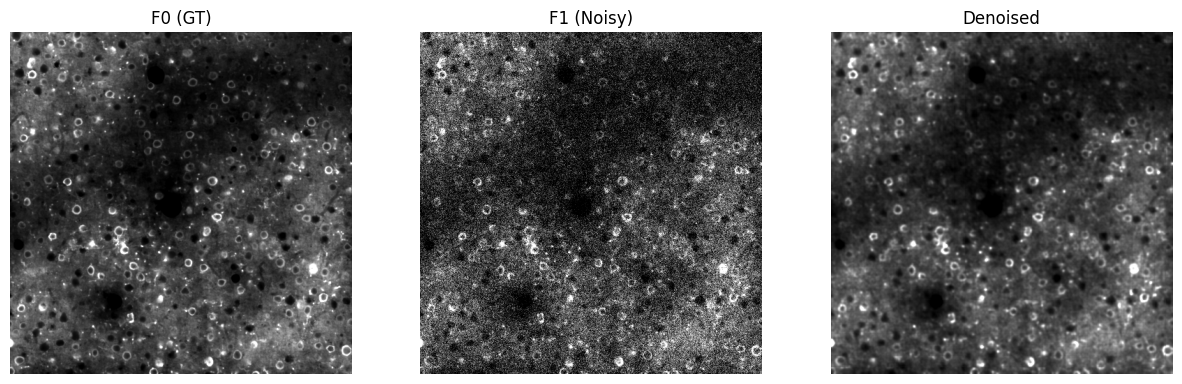

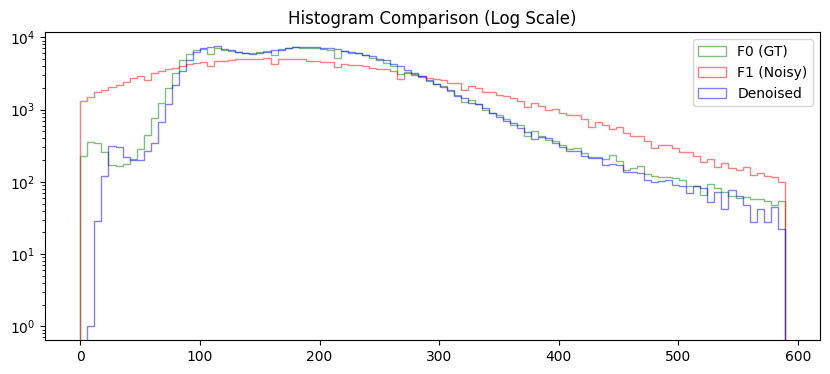

[F0 (GT)] Min: 0.0000, Max: 4277.0000, Mean: 193.1924, Median: 183.0000
[F1 (Noisy)] Min: -233.0000, Max: 4483.0000, Mean: 192.9887, Median: 161.0000
[Denoised] Min: 15.0863, Max: 1389.9989, Mean: 196.1269, Median: 187.5577


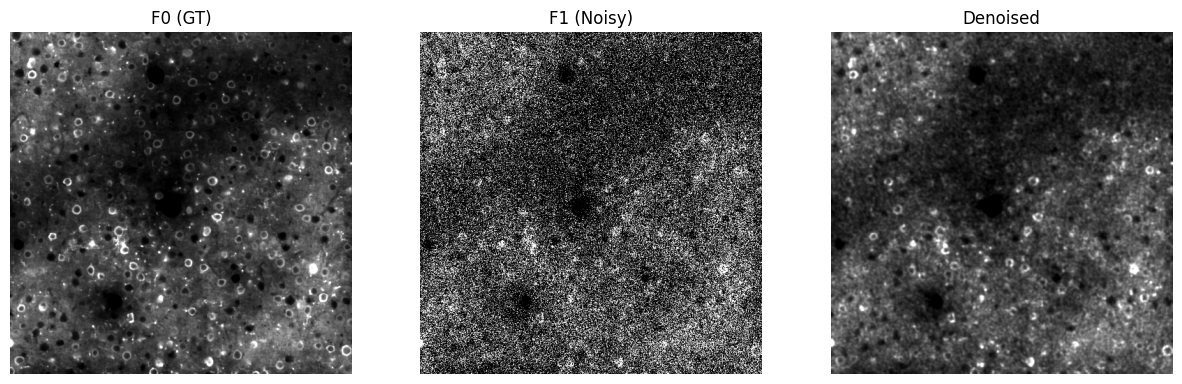

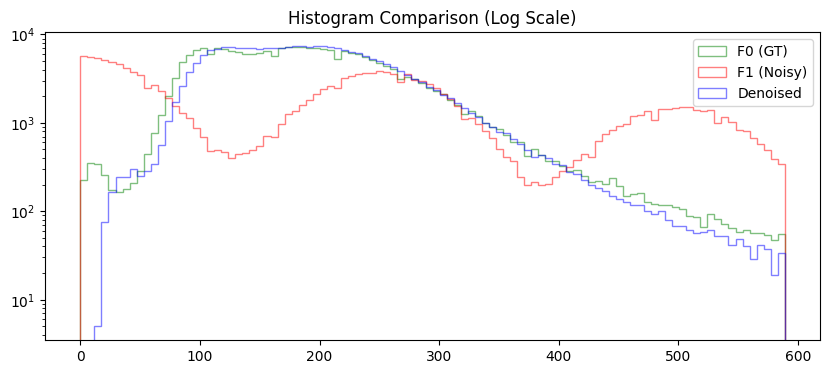

[F0 (GT)] Min: 0.0000, Max: 4277.0000, Mean: 193.1924, Median: 183.0000
[F1 (Noisy)] Min: -228.0000, Max: 6958.0000, Mean: 194.9120, Median: 14.0000
[Denoised] Min: 17.3071, Max: 1175.4508, Mean: 190.7936, Median: 182.5318


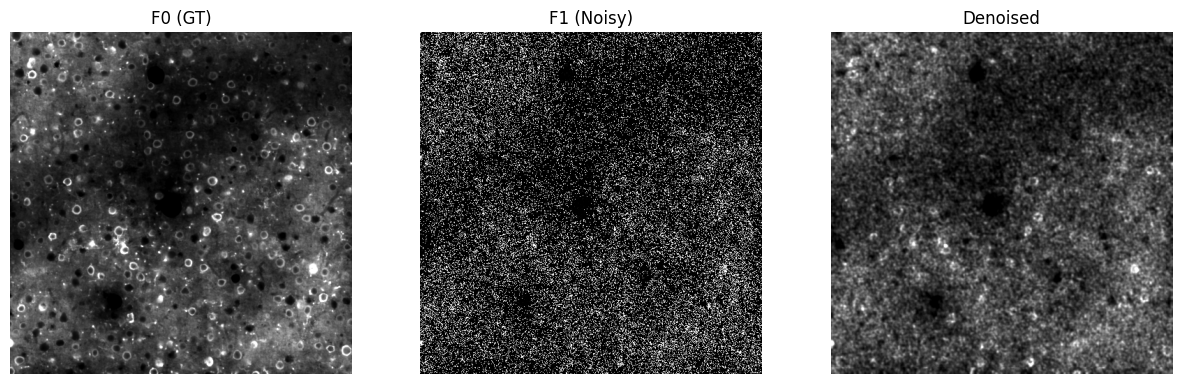

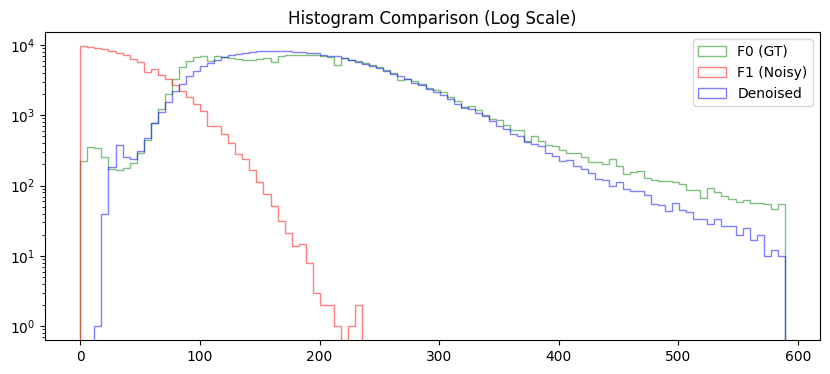

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def inspect_brightness(f0, f1, denoised):
    """
    輸入三個影像 (假設都是 Numpy Array)
    """
    imgs = [f0[0], f1[0], denoised[0]]
    names = ['F0 (GT)', 'F1 (Noisy)', 'Denoised']

    plt.figure(figsize=(15, 5))

    for i, (img, name) in enumerate(zip(imgs, names)):
        # 1. 印出統計數值 (最準確)
        print(f"[{name}] Min: {img.min():.4f}, Max: {img.max():.4f}, Mean: {img.mean():.4f}, Median: {np.median(img):.4f}")

        # 2. 畫圖 (用同樣的 vmin/vmax 比較才公平)
        # 我們統一用 F0 的標準來看
        vmin, vmax = np.percentile(f0, (1, 99.5))

        plt.subplot(1, 3, i+1)
        plt.title(name)
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        plt.axis('off')

    plt.show()

    # 3. 畫直方圖 (檢查背景有沒有偏移)
    plt.figure(figsize=(10, 4))
    plt.title("Histogram Comparison (Log Scale)")
    for img, name, color in zip(imgs, names, ['green', 'red', 'blue']):
        # flatten 拉平，bins 設多一點
        plt.hist(img.flatten(), bins=100, range=(np.percentile(f0, 0), np.percentile(f0, 99.5)),
                 alpha=0.5, label=name, color=color, log=True, histtype='step')
    plt.legend()
    plt.show()


inspect_brightness(ground_truth, valid_dataset.images[0], denoised_videos[0])
inspect_brightness(ground_truth, valid_dataset.images[1], denoised_videos[1])
inspect_brightness(ground_truth, valid_dataset.images[2], denoised_videos[2])

In [ ]:
from matplotlib import axes
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interact_viewer(gt, noised, denoised):
    vmin, vmax = np.percentile(gt, (2, 70))
    # vmin, vmax = gt.min(), gt.max()
    print(vmin, vmax)

    def view_frame(t):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(gt[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[0, 0].set_title(f"Gound Truth (t={t})")
        axs[0, 0].axis('off')

        axs[0, 1].axis('off')

        axs[1, 0].imshow(noised[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[1, 0].set_title(f"Noised (t={t})")
        axs[1, 0].axis('off')

        axs[1, 1].imshow(denoised[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[1, 1].set_title(f"Denoised (t={t})")
        axs[1, 1].axis('off')

        plt.show()

    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(gt)-1,
        step=1,
        description='Time Frame:'
    )

    widgets.interact(view_frame, t=slider)

# interact_viewer(ground_truth, valid_dataset.images[0], denoised_videos[0])
# interact_viewer(valid_dataset.images[0], valid_dataset.images[1])